<a href="https://colab.research.google.com/github/TaufiqHassan/cloud_CMIP6/blob/master/cloud_cmip6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Calculating CMIP6 NAO index**

This Notebook takes advantage of the CMIP6 data in Google cloud platform. More about this can be found here: https://console.cloud.google.com/marketplace/details/noaa-public/cmip6

In [1]:
## Getting the required libs and packages
! apt-get install libproj-dev proj-data proj-bin
! apt-get install libgeos-dev
! pip install --no-binary shapely shapely --force
! pip install cython
! pip install cartopy
! pip install --upgrade zarr gcsfs cftime nc-time-axis netcdf4
! pip install eofs
! pip install xarray==0.15.0
! pip install --upgrade bokeh tornado distributed

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
  Using cached https://files.pythonhosted.org/packages/44/ec/4eddbf9d17a917c51fb4ad159aa7137f506681e91ab559cf87d120e1d78d/Shapely-1.7.0.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.0
    Uninstalling Shapely-1.7.0:
      Successfully uninstalled Shapely-1.7.0
    Runnin

In [0]:
## Import required packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import warnings
warnings.simplefilter("ignore")

In [2]:
## Initializing dask for parallel computing
from dask.distributed import Client, progress
# if __name__ == "__main__":
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:32827 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 13.65 GB


In [0]:
### Used to view the Dask dashboard in Google Colab
## Comment out if not required
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 8787 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

The data catalog is stored in a CSV file that can be accessed via pandas as a dataframe.

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [5]:
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
...,...,...,...,...,...,...,...,...,...,...
269211,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,Omon,tos,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN
269212,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,Omon,uo,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN
269213,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,Omon,vo,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN
269214,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,Omon,wo,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN


Accessing data for ALL forcing CMIP6 simulations

In [0]:
df_psl=df.query("activity_id=='CMIP' & table_id=='Amon' & experiment_id == 'historical' & variable_id=='psl'")
df_psl_ssp=df.query("activity_id=='ScenarioMIP' & table_id=='Amon' & experiment_id == 'ssp245' & variable_id=='psl'")

In [7]:
df_psl_ssp.groupby(['source_id'])['zstore'].count()

source_id
ACCESS-CM2          3
ACCESS-ESM1-5       3
AWI-CM-1-1-MR       1
BCC-CSM2-MR         1
CAMS-CSM1-0         2
CESM2-WACCM         5
CIESM               1
CNRM-CM6-1         10
CNRM-CM6-1-HR       1
CNRM-ESM2-1         5
CanESM5            50
CanESM5-CanOE       3
EC-Earth3           6
EC-Earth3-Veg       4
FGOALS-f3-L         1
FGOALS-g3           1
FIO-ESM-2-0         3
GFDL-CM4            1
GFDL-ESM4           3
GISS-E2-1-G        10
HadGEM3-GC31-LL     4
INM-CM4-8           1
INM-CM5-0           1
IPSL-CM6A-LR       11
KACE-1-0-G          3
MCM-UA-1-0          1
MIROC-ES2L          1
MIROC6              3
MPI-ESM1-2-HR       2
MPI-ESM1-2-LR      10
MRI-ESM2-0          5
NESM3               2
NorESM2-LM          3
NorESM2-MM          1
UKESM1-0-LL         5
Name: zstore, dtype: int64

In [22]:
## Getting all the common models between historical and ssp245 experiments
amoc_models = models=['MRI-ESM2-0','ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-Veg',
       'GFDL-CM4', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NESM3',
       'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']
models_hist = np.intersect1d(list(df_psl['source_id'].unique()),amoc_models)
models_ssp = np.intersect1d(list(df_psl_ssp['source_id'].unique()),amoc_models)
common_models=list(set(models_ssp) & set(models_hist))
common_models

['INM-CM5-0',
 'CNRM-ESM2-1',
 'MPI-ESM1-2-HR',
 'UKESM1-0-LL',
 'NorESM2-MM',
 'MRI-ESM2-0',
 'CanESM5',
 'GFDL-CM4',
 'NorESM2-LM',
 'ACCESS-ESM1-5',
 'MPI-ESM1-2-LR',
 'MIROC6',
 'IPSL-CM6A-LR',
 'HadGEM3-GC31-LL',
 'EC-Earth3-Veg',
 'MIROC-ES2L',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CAMS-CSM1-0',
 'ACCESS-CM2',
 'INM-CM4-8',
 'BCC-CSM2-MR',
 'NESM3']

## **All required functions**

In [0]:
def get_data(source_id, expt_id, exp2='ssp245'):
  '''
  1) Loads data using zarr from Google cloud 
  2) combines historical with ssp245
  '''
    uri = df_psl[(df_psl.source_id == source_id) &
                         (df_psl.experiment_id == expt_id)].zstore.values[0]
    uri_ssp = df_psl_ssp[(df_psl_ssp.source_id == source_id) &
                         (df_psl_ssp.experiment_id == exp2)].zstore.values[0]
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds1 = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    ds2 = xr.open_zarr(gcs.get_mapper(uri_ssp), consolidated=True)
    ds = xr.concat([ds1, ds2], dim='time')
    return ds

def get_lon(val):
    '''
    Converts data to 180W to 180E longitude format
    '''
    lon=(((val.lon + 180) % 360) - 180)
    val.coords['lon']=lon
    val = val.sortby(val.lon)
    return val

def get_EOF(model):
  '''
  Calculates EOF1 and PC1 from SLP data
  '''
  ds=get_data(model, expt_id='historical')['psl'].sel(time=slice('1899', '2020')).load()*.01
  try:
    ds = ds.rename({'longitude':'lon','latitude':'lat'})
  except:
    pass
  ds_lon = get_lon(ds)
  atl = (ds_lon).sel(lon=slice(-90,40),lat=slice(20,80))
  clim = atl.groupby('time.month').mean('time')
  anom = atl.groupby('time.month') - clim
  ds_DJFM = anom.where((anom['time.month'] == 12) | (anom['time.month'] == 1) | (anom['time.month'] == 2) | (anom['time.month'] == 3))
  ds_DJFM = ds_DJFM.rolling(min_periods=4, center=True, time=4).mean()
  ds_DJFM = ds_DJFM.groupby('time.year').mean('time')
  ds_DJFM=ds_DJFM.rename({'year':'time'})
  coslat = np.cos(np.deg2rad(ds_DJFM.coords['lat'].values)).clip(0., 1.)
  wgts = np.sqrt(coslat)[..., np.newaxis]
  solver_djfm = Eof(ds_DJFM[1:], weights=wgts)
  pc_djfm = solver_djfm.pcs(npcs=1, pcscaling=1)
  # Retrieve the leading EOF, expressed as the covariance between the leading PC
  # time series and the input SLP anomalies at each grid point.
  eof1 = solver_djfm.eofsAsCovariance(neofs=1)
  return eof1, pc_djfm.to_dataframe()['pcs'].values

def get_plot(eof1,model,axs):
  '''
  Plots EOF1
  '''
  clevs = np.linspace(-6., 6., 11)
  eof1[0].plot.contourf(ax=axs, level=clevs, cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(), add_colorbar=False)
  axs.set_title(model)

## **Plotting EOF1 and PC1 timeseries**

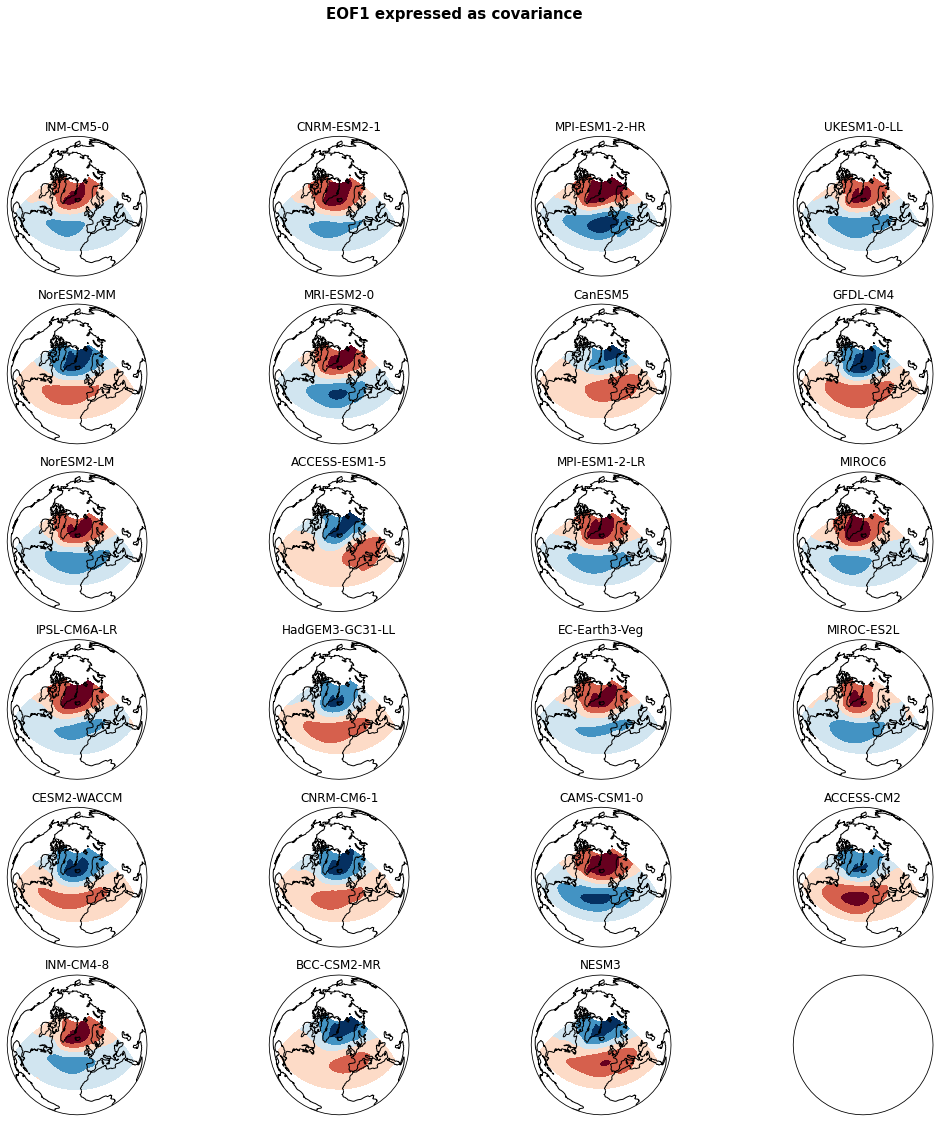

In [32]:
## Plot the leading EOF expressed as covariance in the European/Atlantic domain.
proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
fig, axs = plt.subplots(6,4,figsize=[18,18],subplot_kw=dict(projection=proj))
fig.suptitle('EOF1 expressed as covariance',fontsize=15,weight='bold')
m=0
n=0
for i in range(0,23):
  if common_models[i]!='FGOALS-g3':
    # print('for Model: ',common_models[i])
    eof_data = get_EOF(common_models[i])
    # print('Plotting now . . ')
    get_plot(eof_data[0],common_models[i],axs[n,m])
    axs[n,m].coastlines()
    axs[n,m].set_global()
    m=m+1
    if m>3:
      m=0
      n=n+1
    else:
      continue

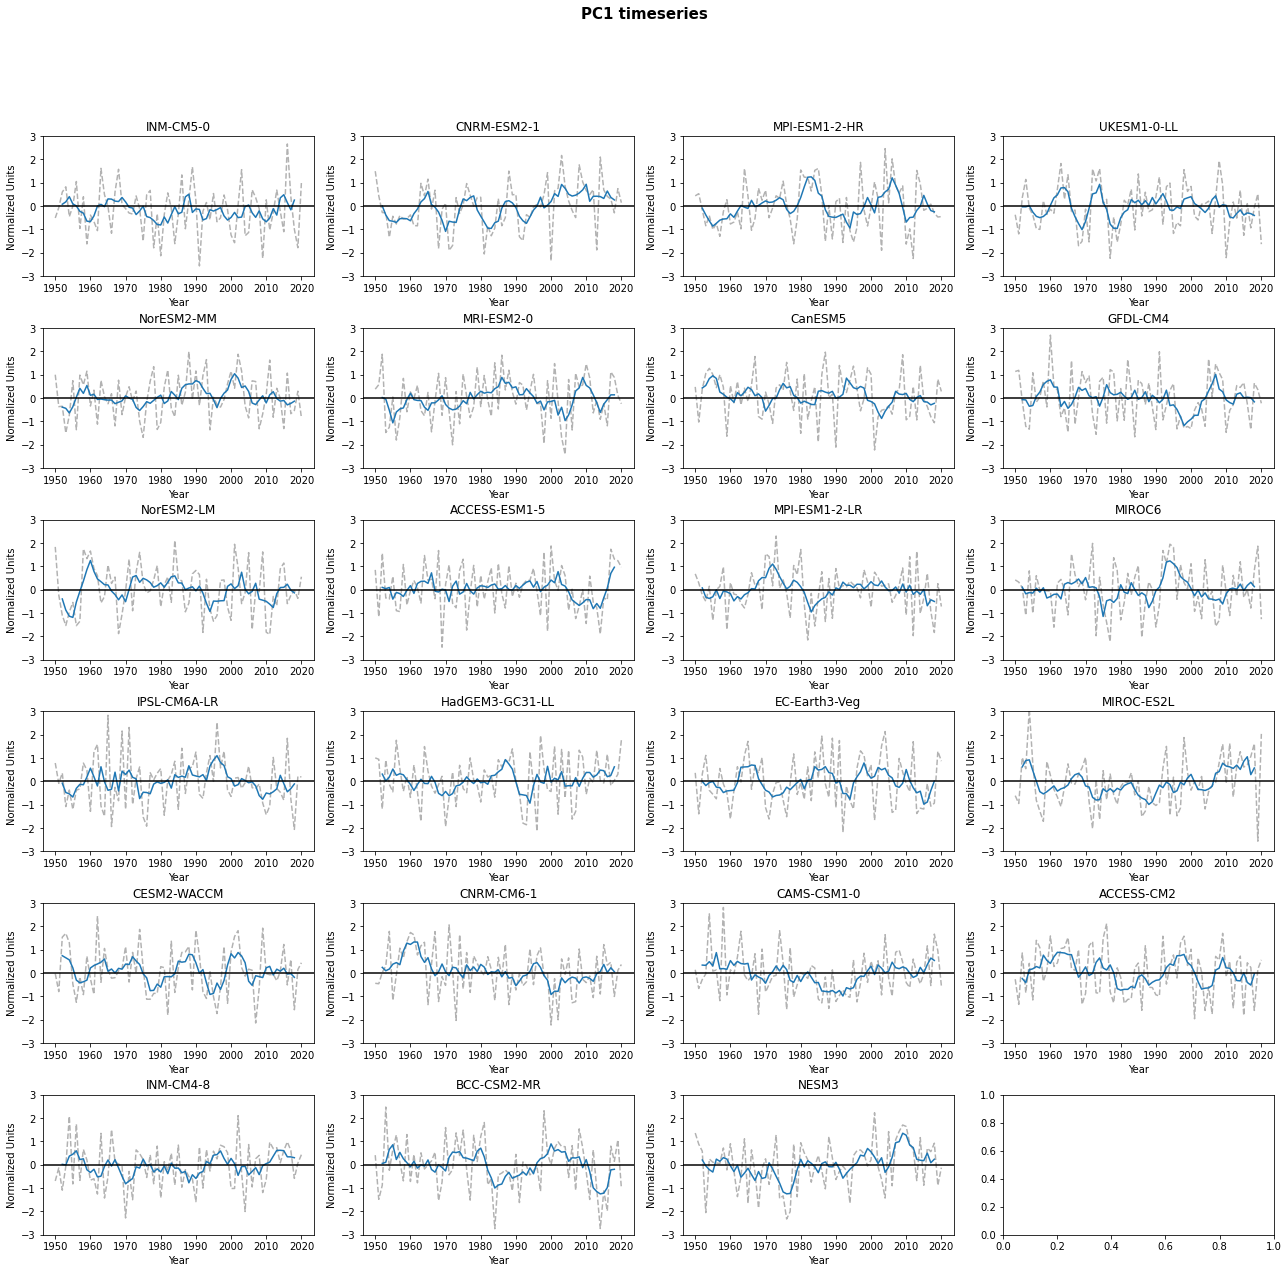

In [42]:
# Plot the leading PC time series.
y = list(range(1900,2021))
fig, axs = plt.subplots(6,4,figsize=[18,18])
fig.suptitle('PC1 timeseries',fontsize=15,weight='bold')
m=0
n=0
for i in range(0,23):
  if common_models[i]!='FGOALS-g3':
    # print('for Model: ',common_models[i])
    eof_data = get_EOF(common_models[i])
    axs[n,m].plot(y[50:],pd.DataFrame(eof_data[1][50:]),'k--',alpha=0.3)
    axs[n,m].plot(y[50:],pd.DataFrame(eof_data[1][50:]).rolling(window=5,center=True).mean())
    axs[n,m].set_title(common_models[i])
    axs[n,m].axhline(0, color='k')
    axs[n,m].set_ylim(-3, 3)
    axs[n,m].set_xlabel('Year')
    axs[n,m].set_ylabel('Normalized Units')
    m=m+1
    if m>3:
      m=0
      n=n+1
    else:
      continue
plt.tight_layout()
fig.subplots_adjust(top=0.88)